In [1]:
from PIL import Image
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tf.keras.backend.clear_session()

In [2]:
def TurnImgBW(directory, savedir, flag):
    i = 0
    for file in os.listdir(directory):
        i += 1 + flag
        filename = os.fsdecode(file)
        image_file = Image.open(os.path.join(directory, filename)) # open colour image
        image_file = image_file.resize((224,224)).convert('L') # convert image to black and white
        newfilename = str(i) + '.png'
        image_file.save(os.path.join(savedir, newfilename))

In [3]:
TurnImgBW('data\\blrfroplastic\\resized\\Before\\', 'data\\blrfroplastic\\resized\\classified\\class0\\', 0)
TurnImgBW('data\\blrfroplastic\\resized\\After\\', 'data\\blrfroplastic\\resized\\classified\\class1\\', 1000)

In [4]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'data\\blrfroplastic\\resized\\classified'

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80% на обучение, 20% на тест
    subset="training",
    seed=123,  # Для воспроизводимости
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 795 files belonging to 2 classes.
Using 636 files for training.
Found 795 files belonging to 2 classes.
Using 159 files for validation.


In [6]:
# Проверка данных
for images, labels in train_ds.take(1):
    print("Размер батча изображений:", images.shape)
    print("Метки:", labels.numpy())

# Проверка данных
for images, labels in val_ds.take(1):
    print("Размер батча изображений:", images.shape)
    print("Метки:", labels.numpy())

Размер батча изображений: (32, 224, 224, 3)
Метки: [0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0]
Размер батча изображений: (32, 224, 224, 3)
Метки: [0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1]


In [7]:
# Слой для аугментации
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Отражение по горизонтали
    tf.keras.layers.RandomRotation(factor=0.083),  # Поворот на ±30 градусов (30°/360° ≈ 0.083)
])

# Пример применения аугментации
def prepare_data_with_augmentation(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x), y))
# Проверка данных
for images, labels in train_ds.take(1):
    print("Размер батча изображений до аугментации:", images.shape)
    print("Метки:", labels.numpy())
# Применяем аугментацию к обучающему датасету
train_ds = prepare_data_with_augmentation(train_ds)

# Проверка данных
for images, labels in train_ds.take(1):
    print("Размер батча изображений после аугментации:", images.shape)
    print("Метки:", labels.numpy())

Размер батча изображений до аугментации: (32, 224, 224, 3)
Метки: [1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0]
Размер батча изображений после аугментации: (32, 224, 224, 3)
Метки: [1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1]


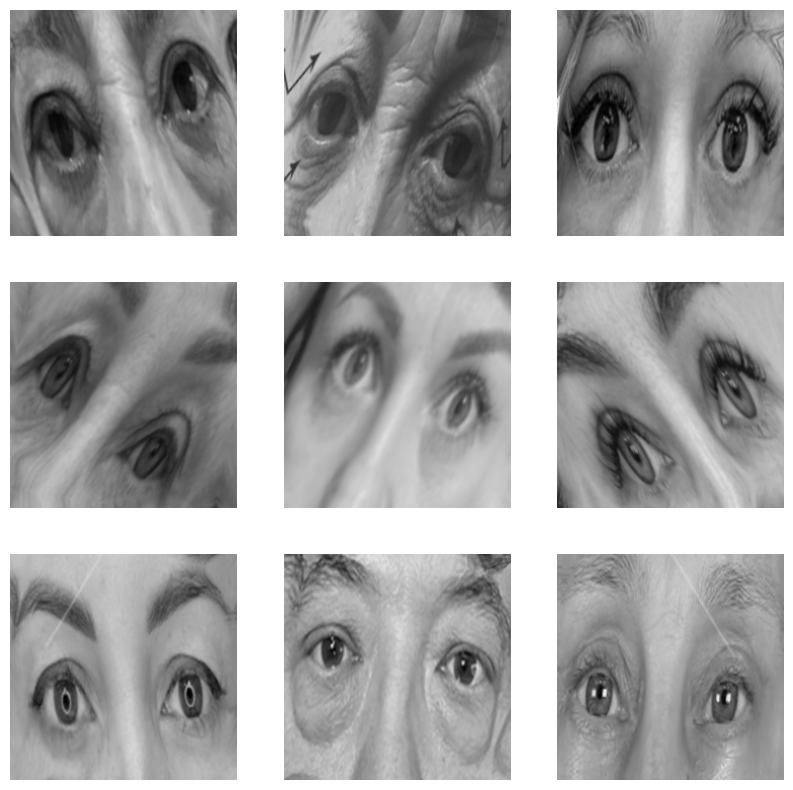

In [8]:
def show_augmented_images(dataset, augmentation_layer, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):  # Берем один батч
        augmented_images = augmentation_layer(images)  # Применяем аугментацию
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Выводим аугментированные изображения
show_augmented_images(train_ds, data_augmentation)

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.applications import EfficientNetB0

class EfficientNetTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs=50, learning_rate=0.001, dense_units=512, dropout_rate=0.5, verbose=0):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.verbose = verbose
        self.model = None

    def build_model(self, input_shape=(224, 224, 3)):
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
        base_model.trainable = False  # Замораживаем базовую модель

        # Создаем модель
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(self.dense_units, activation='relu'),
            layers.Dropout(self.dropout_rate),
            layers.Dense(1, activation='sigmoid')  # Бинарная классификация
        ])

        # Компиляция модели
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, dataset):
        # Строим и обучаем модель
        self.model = self.build_model()
        self.model.fit(dataset, epochs=self.epochs, verbose=self.verbose)
        return self

    def transform(self, X):
        # EfficientNetTrainer не изменяет данные, поэтому просто возвращаем X
        return X

    def predict(self, dataset):
        if self.model is None:
            raise ValueError("Модель не обучена")
        
        y_pred = []
        for images, _ in dataset:
            y_pred_prob = self.model.predict(images)
            y_pred.extend((y_pred_prob > 0.5).astype(int).flatten())
        return y_pred

    def score(self, dataset):
        if self.model is None:
            raise ValueError("Модель не обучена")

        y_true = []
        y_pred = []
        
        for images, labels in dataset:
            predictions = self.model.predict(images)
            predicted_labels = (predictions > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted_labels.flatten())

        return accuracy_score(y_true, y_pred)

    def evaluate_and_plot_confusion_matrix(self, dataset):
        if self.model is None:
            raise ValueError("Модель не обучена")

        y_true = []
        y_pred = []

        for images, labels in dataset:
            predictions = self.model.predict(images)
            predicted_labels = (predictions > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted_labels.flatten())
        
        # Построение матрицы ошибок
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()
        
        # Возвращаем точность для удобства
        return accuracy_score(y_true, y_pred)

In [10]:
def objective(trial):
    param = {
        'epochs': trial.suggest_categorical('epochs', [10, 20, 30, 40, 50]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'dense_units': trial.suggest_categorical('dense_units', [128, 256, 512, 1024]),
        'dropout_rate': trial.suggest_categorical('dropout_rate', [0, 0.1, 0.2, 0.3, 0.4, 0.5]),
        'verbose': trial.suggest_categorical('verbose', [0])
    }

    # Создаем экземпляр EfficientNetTrainer с заданными параметрами
    efficient_net_model = EfficientNetTrainer(**param)

    # Обучаем модель
    efficient_net_model.fit(train_ds)

    # Получаем оценку точности на тренировочном наборе
    val_accuracy = efficient_net_model.score(train_ds)

    return val_accuracy

In [11]:
import optuna

In [12]:
study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=15)

[I 2024-11-07 20:12:20,196] A new study created in memory with name: no-name-90b572d9-c20b-46eb-8969-300d1f7e5a6b
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:14:06,928] Trial 0 finished with value: 0.8380503144654088 and parameters: {'epochs': 50, 'learning_rate': 3.0466589362577627e-05, 'dense_units': 1024, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 0 with value: 0.8380503144654088.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:15:31,307] Trial 1 finished with value: 0.9292452830188679 and parameters: {'epochs': 40, 'learning_rate': 0.003610658511658162, 'dense_units': 512, 'dropout_rate': 0.1, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:16:37,662] Trial 2 finished with value: 0.839622641509434 and parameters: {'epochs': 30, 'learning_rate': 0.013130227794920428, 'dense_units': 1024, 'dropout_rate': 0.5, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:18:03,451] Trial 3 finished with value: 0.7515723270440252 and parameters: {'epochs': 40, 'learning_rate': 0.0303472023386216, 'dense_units': 1024, 'dropout_rate': 0.5, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:19:10,627] Trial 4 finished with value: 0.85062893081761 and parameters: {'epochs': 30, 'learning_rate': 0.01521610889922919, 'dense_units': 256, 'dropout_rate': 0.4, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:19:42,038] Trial 5 finished with value: 0.7468553459119497 and parameters: {'epochs': 10, 'learning_rate': 2.955883488423777e-05, 'dense_units': 256, 'dropout_rate': 0.3, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:20:49,383] Trial 6 finished with value: 0.8930817610062893 and parameters: {'epochs': 30, 'learning_rate': 0.05787976398515238, 'dense_units': 512, 'dropout_rate': 0, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:21:56,498] Trial 7 finished with value: 0.9056603773584906 and parameters: {'epochs': 30, 'learning_rate': 0.00923720751084998, 'dense_units': 1024, 'dropout_rate': 0.1, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:22:27,620] Trial 8 finished with value: 0.7295597484276729 and parameters: {'epochs': 10, 'learning_rate': 0.026678299312510898, 'dense_units': 512, 'dropout_rate': 0.4, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:24:11,916] Trial 9 finished with value: 0.9182389937106918 and parameters: {'epochs': 50, 'learning_rate': 0.004279574852532352, 'dense_units': 256, 'dropout_rate': 0, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:25:37,492] Trial 10 finished with value: 0.8915094339622641 and parameters: {'epochs': 40, 'learning_rate': 0.00041295182000557185, 'dense_units': 128, 'dropout_rate': 0.1, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:26:26,902] Trial 11 finished with value: 0.9182389937106918 and parameters: {'epochs': 20, 'learning_rate': 0.001453475072739669, 'dense_units': 512, 'dropout_rate': 0, 'verbose': 0}. Best is trial 1 with value: 0.9292452830188679.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 2s 2s/step


[I 2024-11-07 20:28:11,512] Trial 12 finished with value: 0.9638364779874213 and parameters: {'epochs': 50, 'learning_rate': 0.0024978540794919103, 'dense_units': 256, 'dropout_rate': 0.2, 'verbose': 0}. Best is trial 12 with value: 0.9638364779874213.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:29:37,930] Trial 13 finished with value: 0.8694968553459119 and parameters: {'epochs': 40, 'learning_rate': 0.0003307204388098261, 'dense_units': 128, 'dropout_rate': 0.2, 'verbose': 0}. Best is trial 12 with value: 0.9638364779874213.
C:\Users\vboro\AppData\Local\Temp\ipykernel_2236\589444731.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


1/1 [==============================] - 1s 1s/step


[I 2024-11-07 20:31:22,042] Trial 14 finished with value: 0.9292452830188679 and parameters: {'epochs': 50, 'learning_rate': 0.0021389463157144416, 'dense_units': 256, 'dropout_rate': 0.2, 'verbose': 0}. Best is trial 12 with value: 0.9638364779874213.


1/1 [==============================] - 1s 1s/step
Score на обучающем подмножестве:  0.9512578616352201
1/1 [==============================] - 0s 30ms/step


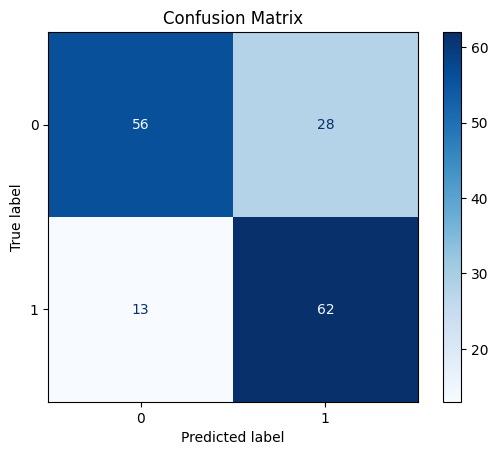

Validation Accuracy with best parameters: 0.74


In [13]:
# Наилучшие параметры, найденные Optuna
best_params = {
    'epochs': 50,
    'learning_rate': 0.0024978540794919103,
    'dense_units': 256,
    'dropout_rate': 0.2,
    'verbose': 0
}

# Создаем и обучаем модель с использованием лучших параметров
model = EfficientNetTrainer(**best_params)
model.fit(train_ds)

print("Score на обучающем подмножестве: ", model.score(train_ds))

# Оцениваем модель на валидационном наборе и выводим матрицу ошибок
val_accuracy = model.evaluate_and_plot_confusion_matrix(val_ds)
print(f"Validation Accuracy with best parameters: {val_accuracy:.2f}")

In [14]:
model.model.save_weights("best_model_weights_eyes.h5")